In [0]:
#!pip install tensorflow==2

In [2]:
import keras.backend as K
import numpy as np
import tensorflow as tf

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

Using TensorFlow backend.


TensorFlow version: 2.0.0
Eager execution: True


In [3]:
@tf.custom_gradient
def O2RU(x):
    r=2
    g =  r*(r**2 * K.abs(x) + 1)**((1-r)/r)
    def grad(dy):
      return dy * g #dy = 1 
    return K.sign(x)*((r**2 * K.abs(x) + 1)**(1/r) - 1), grad

@tf.custom_gradient
def O3RU(x):
    r=3
    g =  r*(r**2 * K.abs(x) + 1)**((1-r)/r)
    def grad(dy):
      return dy * g #dy = 1 
    return K.sign(x)*((r**2 * K.abs(x) + 1)**(1/r) - 1), grad


# if you want to check diff in 0, automatic diff by TF gives 0 but it should be r
with tf.GradientTape() as g:
  x = tf.constant([0.0])
  g.watch(x)
  y = O3RU(x)
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor([3.], shape=(1,), dtype=float32)


In [4]:
@tf.custom_gradient
def E2RU(x):
  r = 2
  gradient = tf.where(x >= 0, r*(r**2 * x + 1)**((1-r)/r), r*K.exp(r*x))
  def grad(dy):
      return dy * gradient
  return tf.where(x >= 0, (r**2 * x + 1)**(1/r) - 1/r, K.exp(r*x) - 1/r), grad

with tf.GradientTape() as g:
  x = tf.constant([-5.0,0.0,5.0,10.0,100.0])
  g.watch(x)
  y = E2RU(x)
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor([9.0799862e-05 2.0000000e+00 4.3643579e-01 3.1234753e-01 9.9875234e-02], shape=(5,), dtype=float32)


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train/255.0).reshape(x_train.shape[0], 28,28,1)
x_test = (x_test/255.0).reshape(x_test.shape[0], 28,28,1)
print(x_train.shape)
print(x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [0]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
features, labels = next(iter(train_dataset))

print(labels)

tf.Tensor(
[3 5 1 2 7 1 6 3 4 2 0 9 5 2 9 3 8 8 6 6 9 8 5 9 2 3 3 0 3 8 0 3 3 6 4 7 3
 7 0 3 4 3 9 0 7 1 5 5 5 4 7 5 4 2 5 1 2 2 6 2 1 7 8 1], shape=(64,), dtype=uint8)


In [0]:
tf.compat.v1.set_random_seed(0)
model_oru = tf.keras.Sequential([
  tf.keras.layers.Flatten(),                        
  tf.keras.layers.Dense(128, activation=O3RU),
  tf.keras.layers.Dense(128, activation=O3RU),
  tf.keras.layers.Dense(128, activation=O3RU),
  tf.keras.layers.Dense(128, activation=O3RU),
  tf.keras.layers.Dense(128, activation=O2RU),
  tf.keras.layers.Dense(128, activation=O2RU),
  tf.keras.layers.Dense(128, activation=O2RU),
  tf.keras.layers.Dense(128, activation=O2RU),
  tf.keras.layers.Dense(10, activation='softmax')
])

model_relu = tf.keras.Sequential([
  tf.keras.layers.Flatten(),                        
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model_elu = tf.keras.Sequential([
  tf.keras.layers.Flatten(),                        
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),                   
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model_leaky_relu = tf.keras.Sequential([
  tf.keras.layers.Flatten(),                        
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

  

In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables) #gradient

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

loss_value, grads = grad(model_oru, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),loss_value.numpy()))

#optimizer.apply_gradients(zip(grads, model_oru.trainable_variables))

#print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
#                                          loss(model_oru, features, labels, training=True).numpy()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0, Initial Loss: 2.321842670440674


In [0]:
import time

def train(model, data, num_epochs):
  train_loss_results = []
  train_accuracy_results = []

  epoch = 0
  for epoch in range(num_epochs):
    start = time.time()
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 64
    for x, y in data:
      # Optimize the model
      loss_value, grads = grad(model, x, y)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Track progress
      epoch_loss_avg(loss_value)  # Add current batch loss
      # Compare predicted label to actual label
      # training=True is needed only if there are layers with different
      # behavior during training versus inference (e.g. Dropout).
      epoch_accuracy(y, model(x, training=True))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    #if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    print ('Time taken for epoch {} sec\n'.format(time.time() - start))
    epoch +=1
  return train_loss_results, train_accuracy_results

In [0]:
l_bru, a_bru = train(model_oru, train_dataset, 25)

Epoch 000: Loss: 1.759, Accuracy: 74.417%
Time taken for epoch 36.9571008682251 sec

Epoch 001: Loss: 1.666, Accuracy: 82.412%
Time taken for epoch 37.273029804229736 sec

Epoch 002: Loss: 1.653, Accuracy: 83.088%
Time taken for epoch 37.060131549835205 sec

Epoch 003: Loss: 1.646, Accuracy: 83.547%
Time taken for epoch 37.16680717468262 sec

Epoch 004: Loss: 1.641, Accuracy: 83.908%
Time taken for epoch 37.10789513587952 sec

Epoch 005: Loss: 1.637, Accuracy: 84.107%
Time taken for epoch 37.36256718635559 sec

Epoch 006: Loss: 1.635, Accuracy: 84.295%
Time taken for epoch 36.82640290260315 sec

Epoch 007: Loss: 1.632, Accuracy: 84.557%
Time taken for epoch 36.76206922531128 sec

Epoch 008: Loss: 1.630, Accuracy: 84.717%
Time taken for epoch 36.74915170669556 sec

Epoch 009: Loss: 1.627, Accuracy: 84.877%
Time taken for epoch 36.68390226364136 sec

Epoch 010: Loss: 1.626, Accuracy: 84.953%
Time taken for epoch 36.69402289390564 sec

Epoch 011: Loss: 1.624, Accuracy: 85.118%
Time taken 

In [0]:
l_elu, a_elu = train(model_elu, train_dataset, 25)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 2.067, Accuracy: 45.023%
Time taken for epoch 20.80058002471924 sec

Epoch 001: Loss: 1.889, Accuracy: 58.998%
Time taken for epoch 20.783990383148193 sec

Epoch 002: Loss: 1.744, Accuracy: 74.768%
Time taken for epoch 20.953022480010986 sec

Epoch 003: Loss: 1.687, Accuracy: 79.623%
Time taken for epoch 20.914631366729736 sec

Epoch 004: Loss: 1.672, Accuracy: 80.808%
Time taken for epoch 20.88197088241577 sec

Epoch 005: Loss: 1.664, Accuracy: 81.448%
Time taken for epoch 20.730922222

In [0]:
l_relu, a_relu = train(model_relu, train_dataset, 25)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 2.300, Accuracy: 26.118%
Time taken for epoch 20.293411016464233 sec

Epoch 001: Loss: 2.289, Accuracy: 45.902%
Time taken for epoch 20.299880743026733 sec

Epoch 002: Loss: 2.060, Accuracy: 46.873%
Time taken for epoch 20.060285568237305 sec

Epoch 003: Loss: 1.845, Accuracy: 64.173%
Time taken for epoch 20.23908829689026 sec

Epoch 004: Loss: 1.799, Accuracy: 69.667%
Time taken for epoch 20.21367621421814 sec

Epoch 005: Loss: 1.765, Accuracy: 72.280%
Time taken for epoch 20.186950206

In [0]:
l_leaky_relu, a_leaky_relu = train(model_leaky_relu, train_dataset, 25)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 2.300, Accuracy: 18.430%
Time taken for epoch 21.018362283706665 sec

Epoch 001: Loss: 2.265, Accuracy: 30.602%
Time taken for epoch 20.867892026901245 sec

Epoch 002: Loss: 1.960, Accuracy: 54.027%
Time taken for epoch 21.151148557662964 sec

Epoch 003: Loss: 1.775, Accuracy: 73.067%
Time taken for epoch 20.960699558258057 sec

Epoch 004: Loss: 1.717, Accuracy: 77.558%
Time taken for epoch 21.130397081375122 sec

Epoch 005: Loss: 1.697, Accuracy: 78.962%
Time taken for epoch 20.9348945

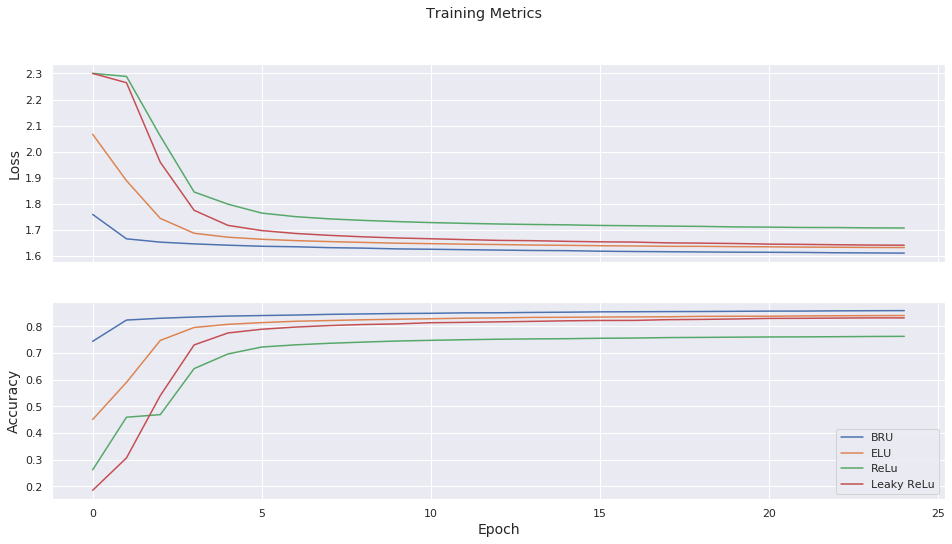

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, axes = plt.subplots(2, sharex=True, figsize=(16, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(l_bru, label='BRU')
axes[0].plot(l_elu, label='ELU')
axes[0].plot(l_relu, label='ReLu')
axes[0].plot(l_leaky_relu, label='Leaky ReLu')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(a_bru, label='BRU')
axes[1].plot(a_elu, label='ELU')
axes[1].plot(a_relu, label='ReLu')
axes[1].plot(a_leaky_relu, label='Leaky ReLu')

plt.legend()
plt.show()

In [0]:
def eval(model, data):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  for x, y in data:
    loss_value, _ = grad(model, x, y)
    epoch_loss_avg(loss_value)
    epoch_accuracy(y, model(x, training=False))
  
  return epoch_loss_avg.result(), epoch_accuracy.result()


In [0]:
l, a = eval(model_oru, test_dataset)
print("Loss: {:.3f}, Accuracy: {:.3%}".format(l,a))

Loss: 1.637, Accuracy: 82.280%


In [0]:
l, a = eval(model_elu, test_dataset)
print("Loss: {:.3f}, Accuracy: {:.3%}".format(l,a))

Loss: 1.647, Accuracy: 81.410%


In [0]:
l, a = eval(model_relu, test_dataset)
print("Loss: {:.3f}, Accuracy: {:.3%}".format(l,a))

Loss: 1.718, Accuracy: 74.270%


In [0]:
l, a = eval(model_leaky_relu, test_dataset)
print("Loss: {:.3f}, Accuracy: {:.3%}".format(l,a))

Loss: 1.652, Accuracy: 80.860%


In [0]:
tf.compat.v1.set_random_seed(0)
model_bru = tf.keras.Sequential([
  tf.keras.layers.Flatten(),                        
  tf.keras.layers.Dense(128, activation=O3RU),
  tf.keras.layers.Dense(128, activation=O3RU),
  tf.keras.layers.Dense(128, activation=O3RU),
  tf.keras.layers.Dense(128, activation=O3RU),
  tf.keras.layers.Dense(128, activation=O2RU),
  tf.keras.layers.Dense(128, activation=O2RU),
  tf.keras.layers.Dense(128, activation=O2RU),
  tf.keras.layers.Dense(128, activation=O2RU),
  tf.keras.layers.Dense(10, activation='softmax')
])

model_relu = tf.keras.Sequential([
  tf.keras.layers.Flatten(),                        
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model_elu = tf.keras.Sequential([
  tf.keras.layers.Flatten(),                        
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),                   
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model_leaky_relu = tf.keras.Sequential([
  tf.keras.layers.Flatten(),                        
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(10, activation='softmax')
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [0]:
import time
def train_test(model, train_data, test_data, num_epochs):
  train_loss_results = []
  test_loss_results = []

  epoch = 0
  for epoch in range(num_epochs):
    start = time.time()
    epoch_loss_avg = tf.keras.metrics.Mean()
    test_loss_avg = tf.keras.metrics.Mean()

    # Training loop - using batches of 64
    for x, y in train_data:
      # Optimize the model
      loss_value, grads = grad(model, x, y)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      # Track progress
      epoch_loss_avg(loss_value)  # Add current batch loss
      
    for x_test, y_test in test_data:
      loss_test = loss(model, x_test, y_test, False)
      test_loss_avg(loss_test)

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    test_loss_results.append(test_loss_avg.result())
    if epoch % 5 == 0:
      print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
      print("Test Loss: {:.3f}".format(test_loss_avg.result()))
      print ('Time taken for epoch {} sec\n'.format(time.time() - start))
    epoch +=1
  return train_loss_results, test_loss_results

In [25]:
epoch = 100
t_loss_bru, test_loss_bru = train_test(model_bru, train_dataset, test_dataset, epoch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 1.760
Test Loss: 1.692
Time taken for epoch 20.1548330783844 sec

Epoch 005: Loss: 1.638
Test Loss: 1.654
Time taken for epoch 21.21803092956543 sec

Epoch 010: Loss: 1.625
Test Loss: 1.650
Time taken for epoch 21.016664505004883 sec

Epoch 015: Loss: 1.619
Test Loss: 1.644
Time taken for epoch 20.506439208984375 sec

Epoch 020: Loss: 1.615
Test Loss: 1.640
Time taken for epoch 20.293667554855347 sec

Epoch 025: Loss: 1.611
Test Loss: 1.650
Time taken for epoch 20.197365283966064 sec

E

In [26]:
t_loss_elu, test_loss_elu = train_test(model_elu, train_dataset, test_dataset, epoch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 2.067
Test Loss: 1.925
Time taken for epoch 13.0104660987854 sec

Epoch 005: Loss: 1.664
Test Loss: 1.668
Time taken for epoch 13.115968227386475 sec

Epoch 010: Loss: 1.647
Test Loss: 1.657
Time taken for epoch 13.234277725219727 sec

Epoch 015: Loss: 1.640
Test Loss: 1.651
Time taken for epoch 12.977270126342773 sec

Epoch 020: Loss: 1.635
Test Loss: 1.649
Time taken for epoch 13.170380353927612 sec

Epoch 025: Loss: 1.632
Test Loss: 1.646
Time taken for epoch 13.052745342254639 sec



In [27]:
t_loss_relu, test_loss_relu = train_test(model_relu, train_dataset, test_dataset, epoch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 2.300
Test Loss: 2.298
Time taken for epoch 12.34449553489685 sec

Epoch 005: Loss: 1.765
Test Loss: 1.763
Time taken for epoch 11.763380527496338 sec

Epoch 010: Loss: 1.728
Test Loss: 1.735
Time taken for epoch 11.733027219772339 sec

Epoch 015: Loss: 1.717
Test Loss: 1.722
Time taken for epoch 12.858717441558838 sec

Epoch 020: Loss: 1.711
Test Loss: 1.727
Time taken for epoch 12.62708830833435 sec

Epoch 025: Loss: 1.706
Test Loss: 1.717
Time taken for epoch 11.981975078582764 sec



In [28]:
t_loss_leaky_relu, test_loss_leaky_relu = train_test(model_leaky_relu, train_dataset, test_dataset, epoch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 2.300
Test Loss: 2.297
Time taken for epoch 12.054328680038452 sec

Epoch 005: Loss: 1.697
Test Loss: 1.705
Time taken for epoch 11.955799579620361 sec

Epoch 010: Loss: 1.666
Test Loss: 1.675
Time taken for epoch 12.072635173797607 sec

Epoch 015: Loss: 1.654
Test Loss: 1.661
Time taken for epoch 12.140474796295166 sec

Epoch 020: Loss: 1.645
Test Loss: 1.656
Time taken for epoch 12.124380588531494 sec

Epoch 025: Loss: 1.640
Test Loss: 1.653
Time taken for epoch 11.688659191131592 sec

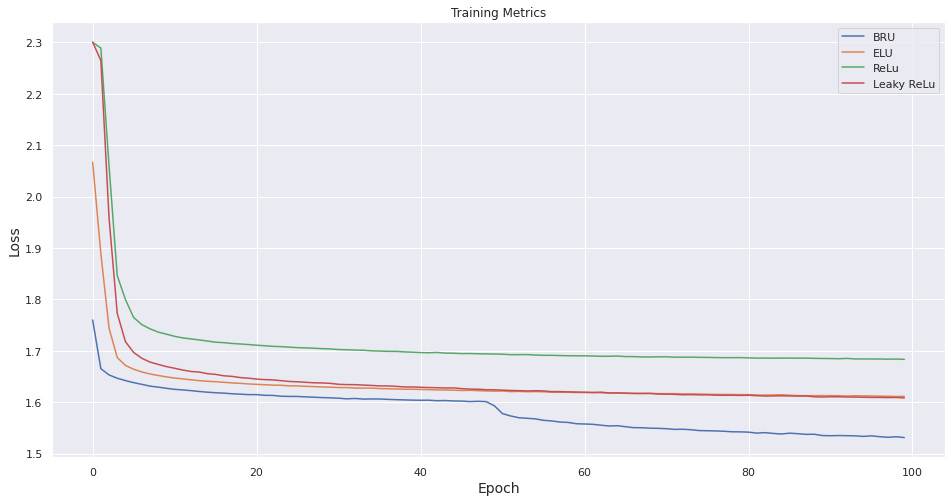

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(16, 8))
plt.title('Training Metrics')

plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.plot(t_loss_bru, label='BRU')
plt.plot(t_loss_elu, label='ELU')
plt.plot(t_loss_relu, label='ReLu')
plt.plot(t_loss_leaky_relu, label='Leaky ReLu')

plt.legend()
plt.show()

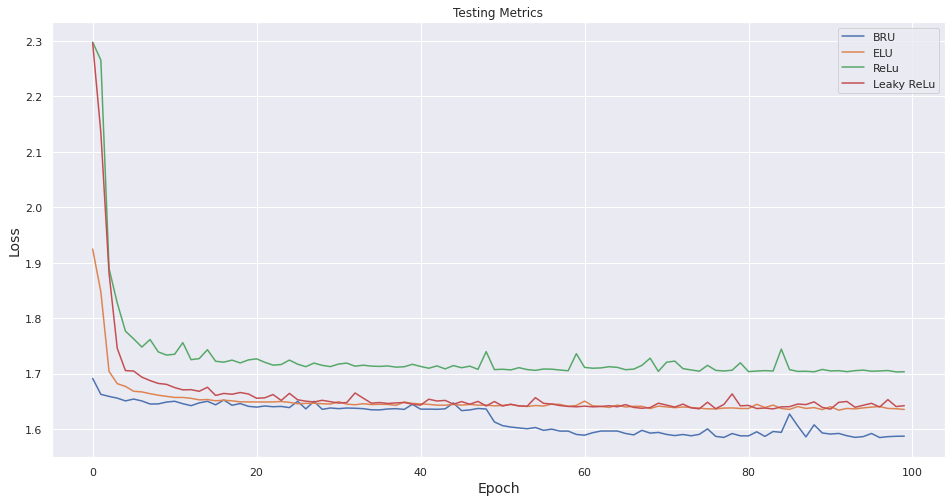

In [30]:
plt.figure(figsize=(16, 8))
plt.title('Testing Metrics')

plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.plot(test_loss_bru, label='BRU')
plt.plot(test_loss_elu, label='ELU')
plt.plot(test_loss_relu, label='ReLu')
plt.plot(test_loss_leaky_relu, label='Leaky ReLu')

plt.legend()
plt.show()

In [0]:
# of corse i forgot to print losses at 100th epoch
def eval_100(train_data, test_data, model):
  train_loss_avg = tf.keras.metrics.Mean()
  test_loss_avg = tf.keras.metrics.Mean()
  for x, y in train_data:
    l = loss(model, x, y, False)
    train_loss_avg(l)
  for x, y in test_data:
    l = loss(model, x, y, False)
    test_loss_avg(l)
  return train_loss_avg.result(), test_loss_avg.result()

In [33]:
l_tr, l_te = eval_100(train_dataset, test_dataset, model_bru)
print(l_tr, l_te)

tf.Tensor(1.5335268, shape=(), dtype=float32) tf.Tensor(1.5873206, shape=(), dtype=float32)


In [36]:
l_tr, l_te = eval_100(train_dataset, test_dataset, model_elu)
print(l_tr, l_te)

tf.Tensor(1.6141874, shape=(), dtype=float32) tf.Tensor(1.6355089, shape=(), dtype=float32)


In [37]:
l_tr, l_te = eval_100(train_dataset, test_dataset, model_relu)
print(l_tr, l_te)

tf.Tensor(1.683478, shape=(), dtype=float32) tf.Tensor(1.7035041, shape=(), dtype=float32)


In [38]:
l_tr, l_te = eval_100(train_dataset, test_dataset, model_leaky_relu)
print(l_tr, l_te)

tf.Tensor(1.6177182, shape=(), dtype=float32) tf.Tensor(1.6423231, shape=(), dtype=float32)
